In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
targets = ["target_CHEMBL240"]
methods = ["RF"]
sorting_vars = ["logp"] #, "pchembl"]

In [3]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

def GetExactMolWt(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.ExactMolWt (mol))
def GetCalcTPSA(s):
    mol = Chem.MolFromSmiles(s)
    return (Chem.rdMolDescriptors.CalcTPSA(mol))
def GetNumRotatableBonds(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumRotatableBonds (mol))
def GetNumHDonors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHDonors(mol))
def GetNumHAcceptors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHAcceptors(mol) )
def GetMolLogP(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.MolLogP(mol))

In [5]:
df = pd.read_csv(f"../data/target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")
            

df['MolWt']=df['Standardized_SMILES'].parallel_apply(GetExactMolWt)
df['TPSA']=df['Standardized_SMILES'].parallel_apply(GetCalcTPSA) #Topological Polar Surface Area
df['nRotB']=df['Standardized_SMILES'].parallel_apply(GetNumRotatableBonds) #Number of rotable bonds
df['HBD']=df['Standardized_SMILES'].parallel_apply(GetNumHDonors) #Number of H bond donors
df['HBA']=df['Standardized_SMILES'].parallel_apply(GetNumHAcceptors) #Number of H bond acceptors
df['LogP']=df['Standardized_SMILES'].parallel_apply(GetMolLogP) #LogP

df

,Standardized_SMILES,pchembl_value,MolWt,TPSA,nRotB,HBD,HBA,LogP
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,360.083725,34.15,5,1,3,3.6821
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.226646,69.72,3,2,3,6.4497
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.221895,81.75,3,3,4,4.8690
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.205910,78.95,3,2,4,5.2960
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.226646,69.72,3,2,3,6.1021
...,...,...,...,...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.162331,78.62,3,3,5,4.3692
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.288912,65.73,3,3,3,5.7135
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.257612,65.73,3,3,3,5.2934
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.226646,69.39,3,3,3,5.4614


In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop(columns=["pchembl_value", "Standardized_SMILES"]))
#pca_result

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Standardized_SMILES'] = df['Standardized_SMILES']

pca_df

,PC1,PC2,Standardized_SMILES
0,-97.668550,-15.955715,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1
1,-51.732914,6.973922,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...
2,-47.217356,18.271554,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...
3,-47.102598,15.265676,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...
4,-51.733691,6.986551,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...
...,...,...,...
1257,-41.485350,13.285223,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...
1258,3.512593,-14.180291,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...
1259,-46.191976,1.166391,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...
1260,-51.830461,6.723962,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...


sortedFCV
target_CHEMBL240
RF
logp


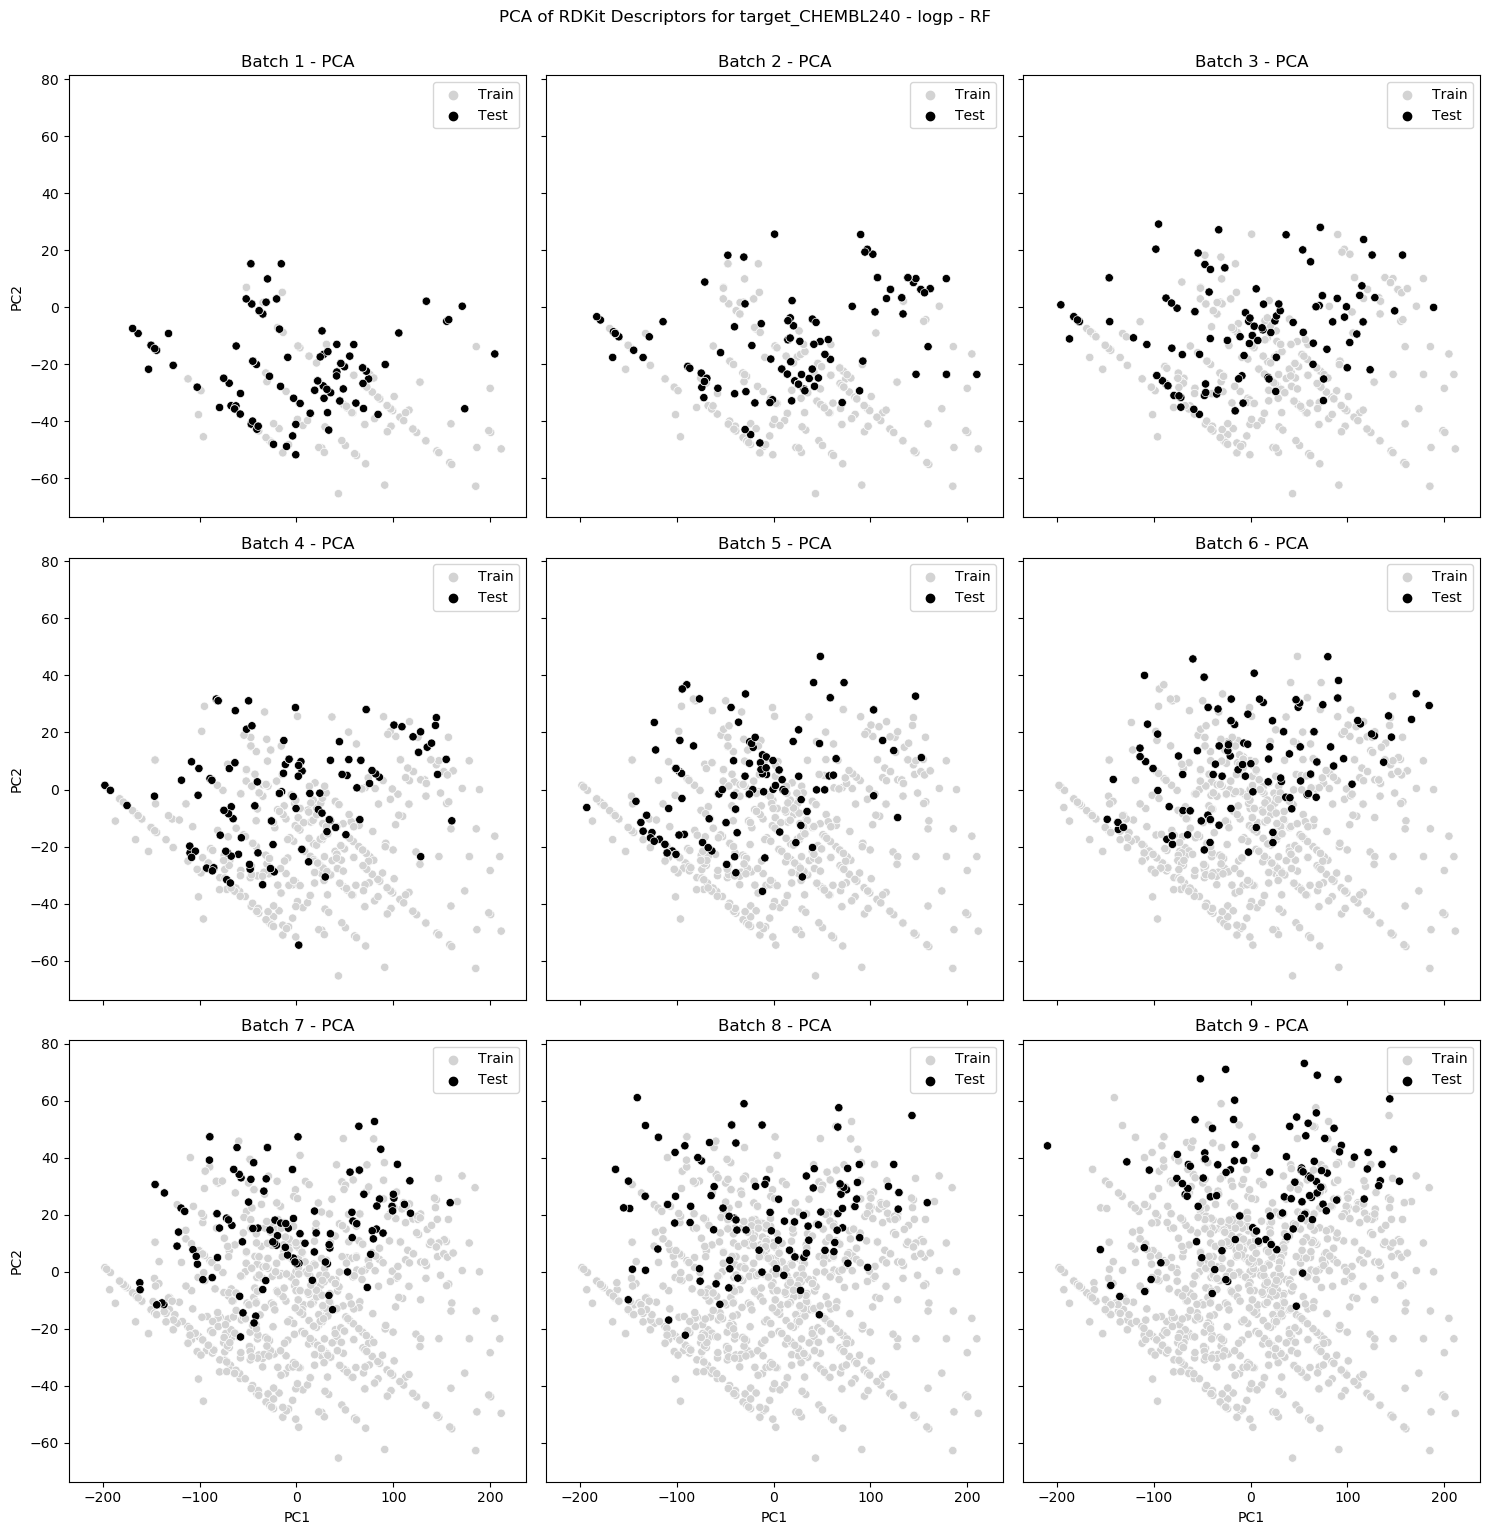

Explained variance by PC1: 0.91
Explained variance by PC2: 0.09


In [7]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("sortedFCV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_training batches.csv")
            
            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

unsortedFCV
target_CHEMBL240
RF
logp


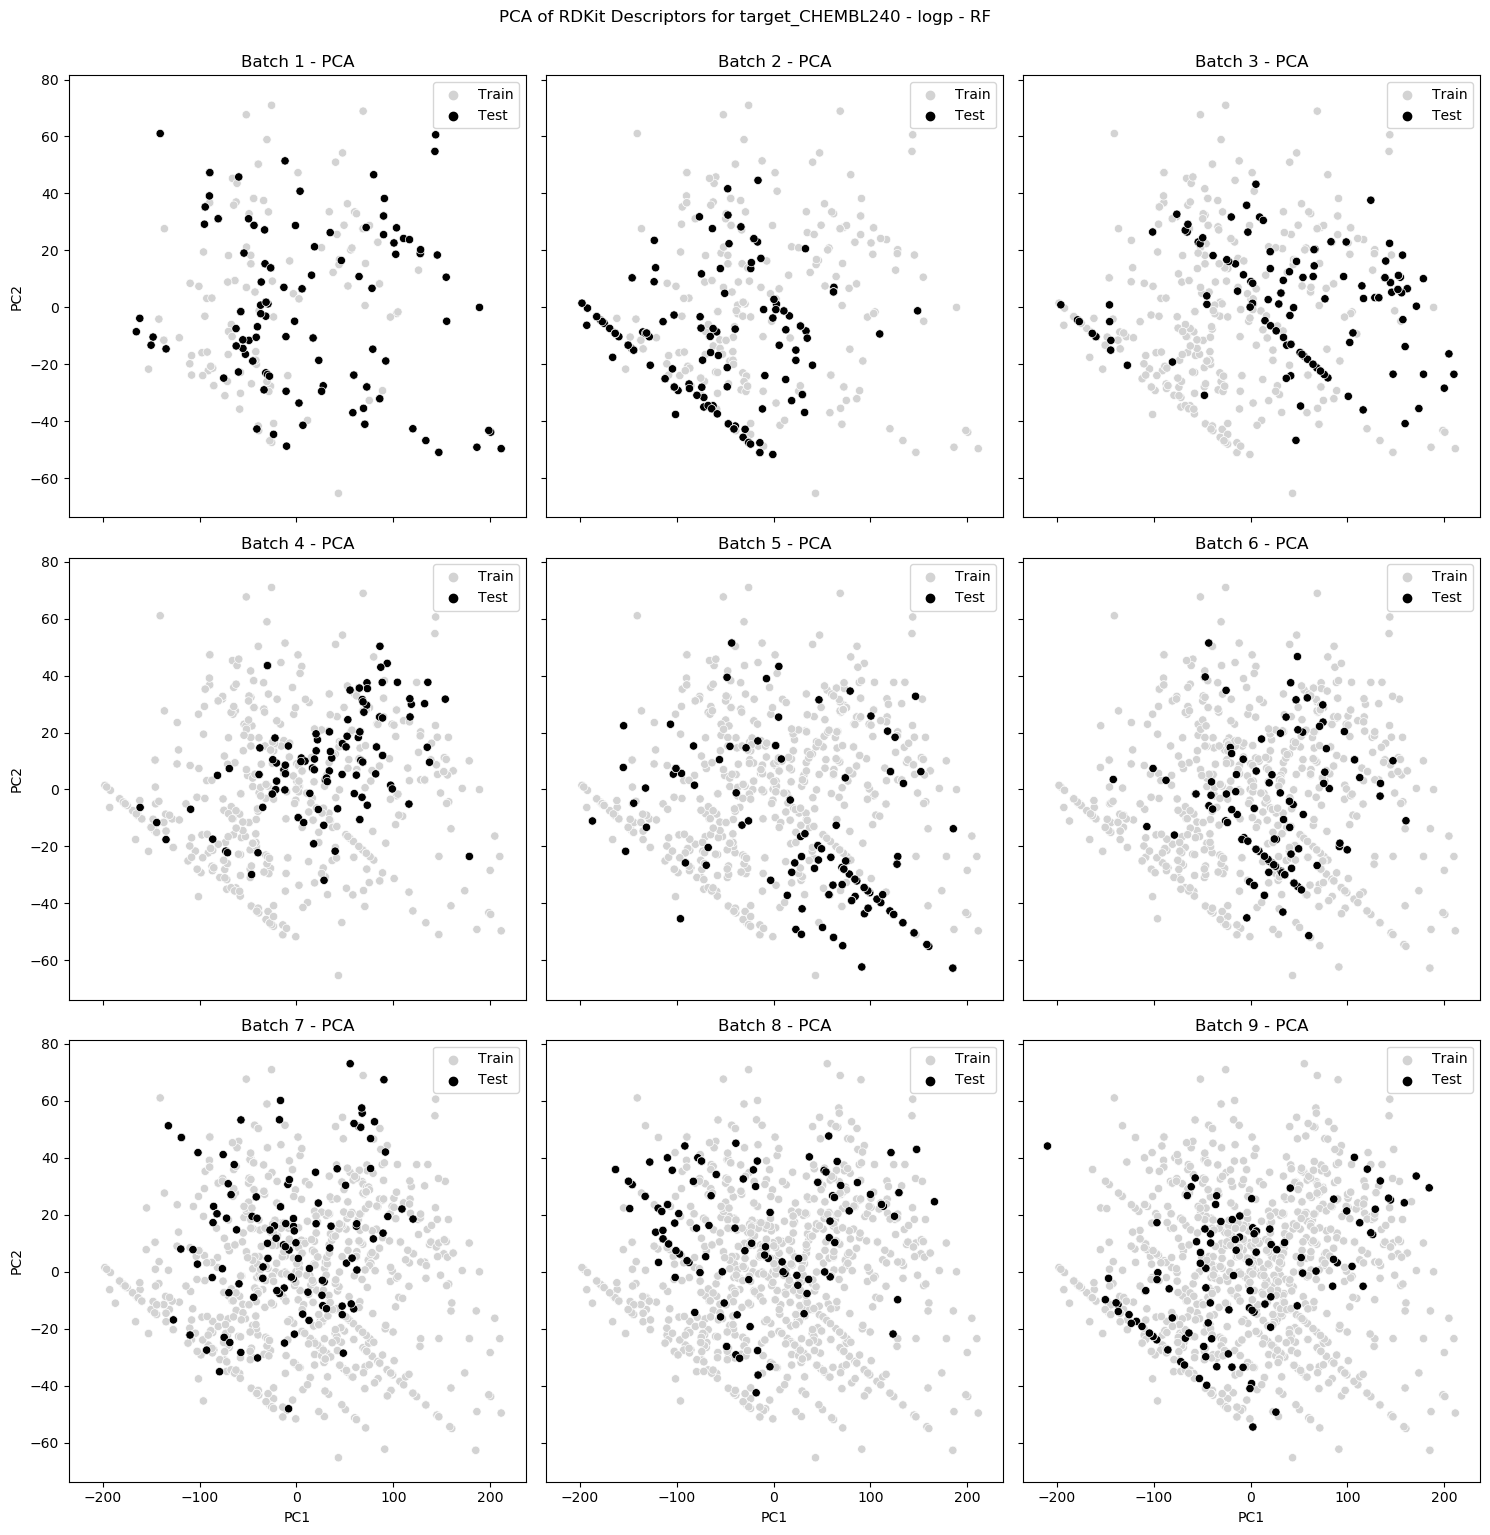

Explained variance by PC1: 0.91
Explained variance by PC2: 0.09


In [8]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("unsortedFCV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break

                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

CV
target_CHEMBL240
RF
logp


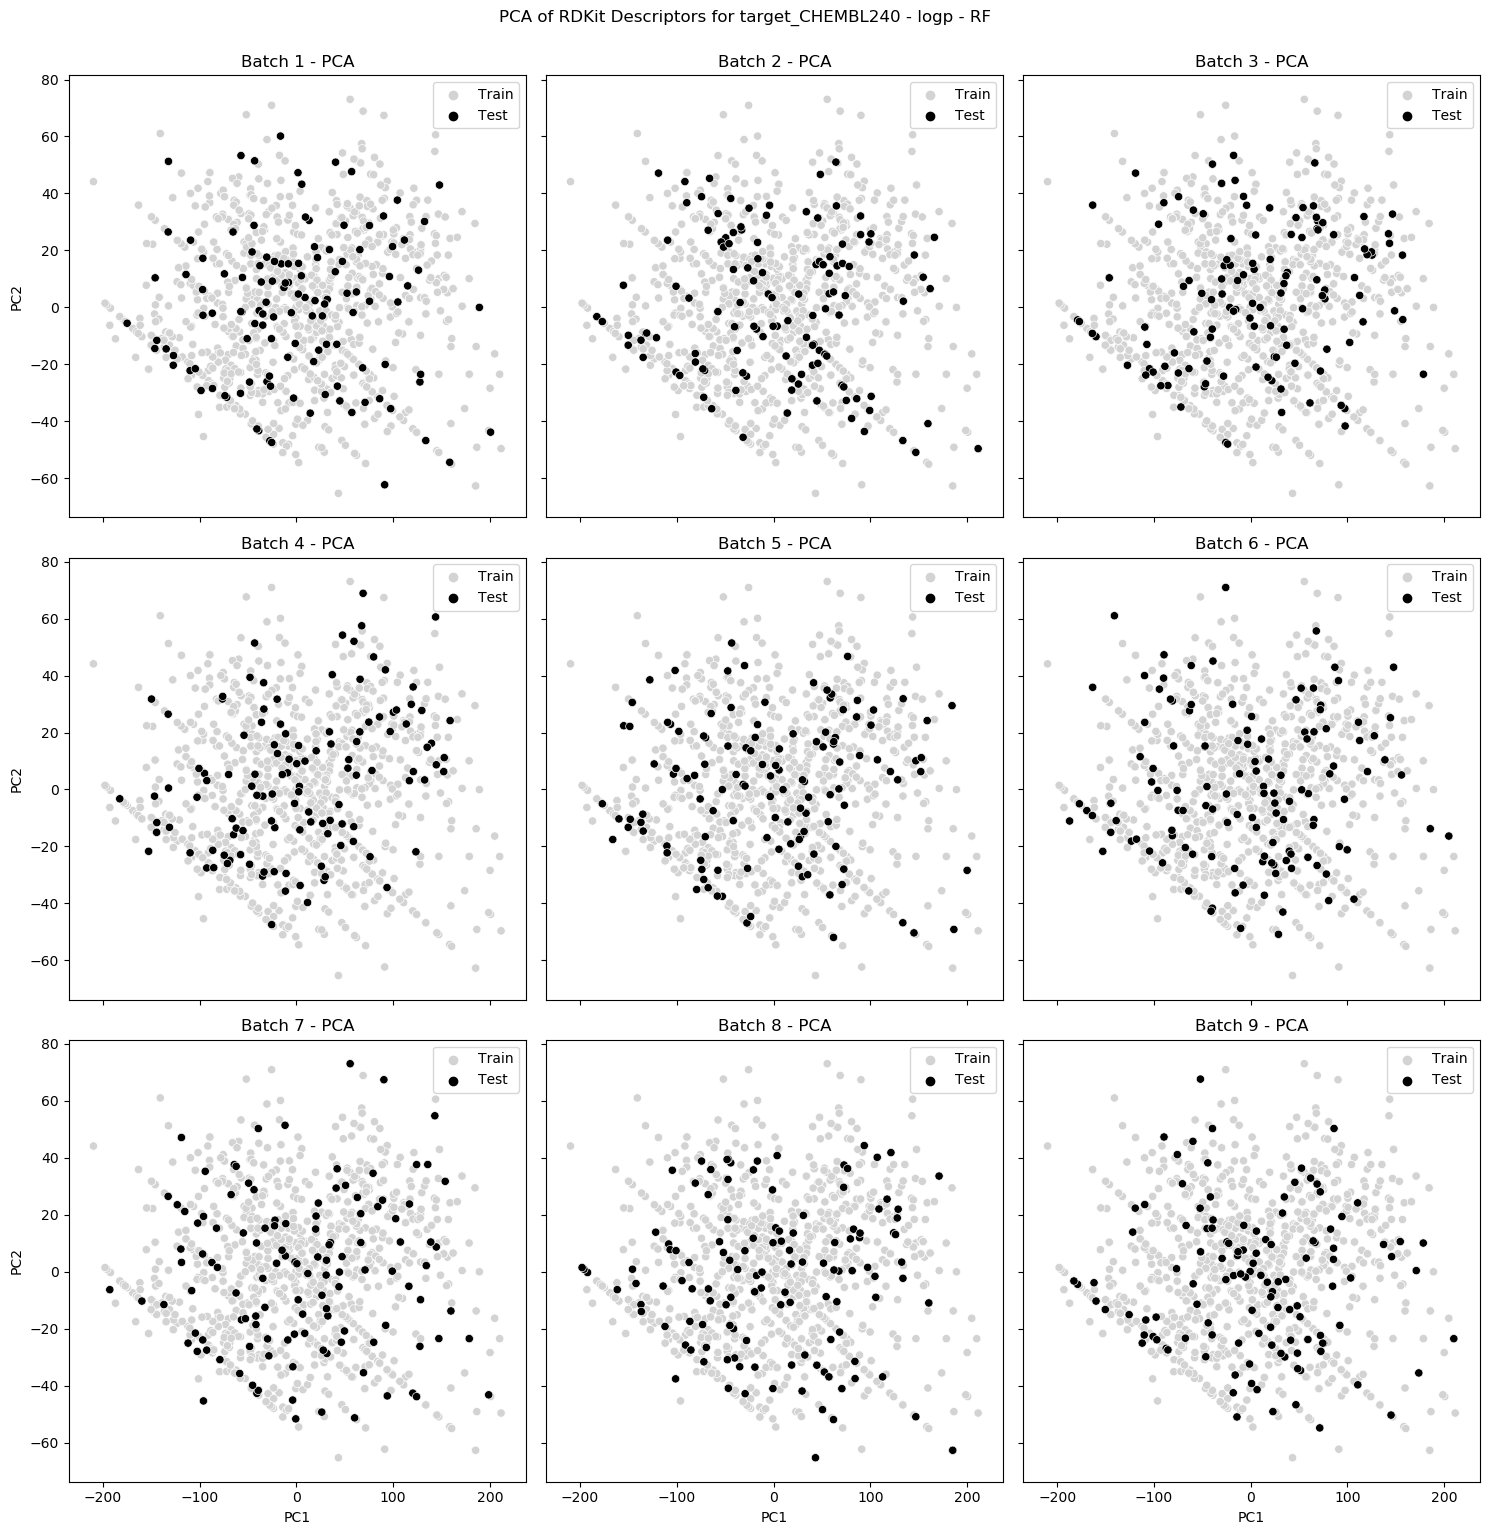

Explained variance by PC1: 0.91
Explained variance by PC2: 0.09


In [9]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("CV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)


            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

CV
target_CHEMBL240
RF
logp


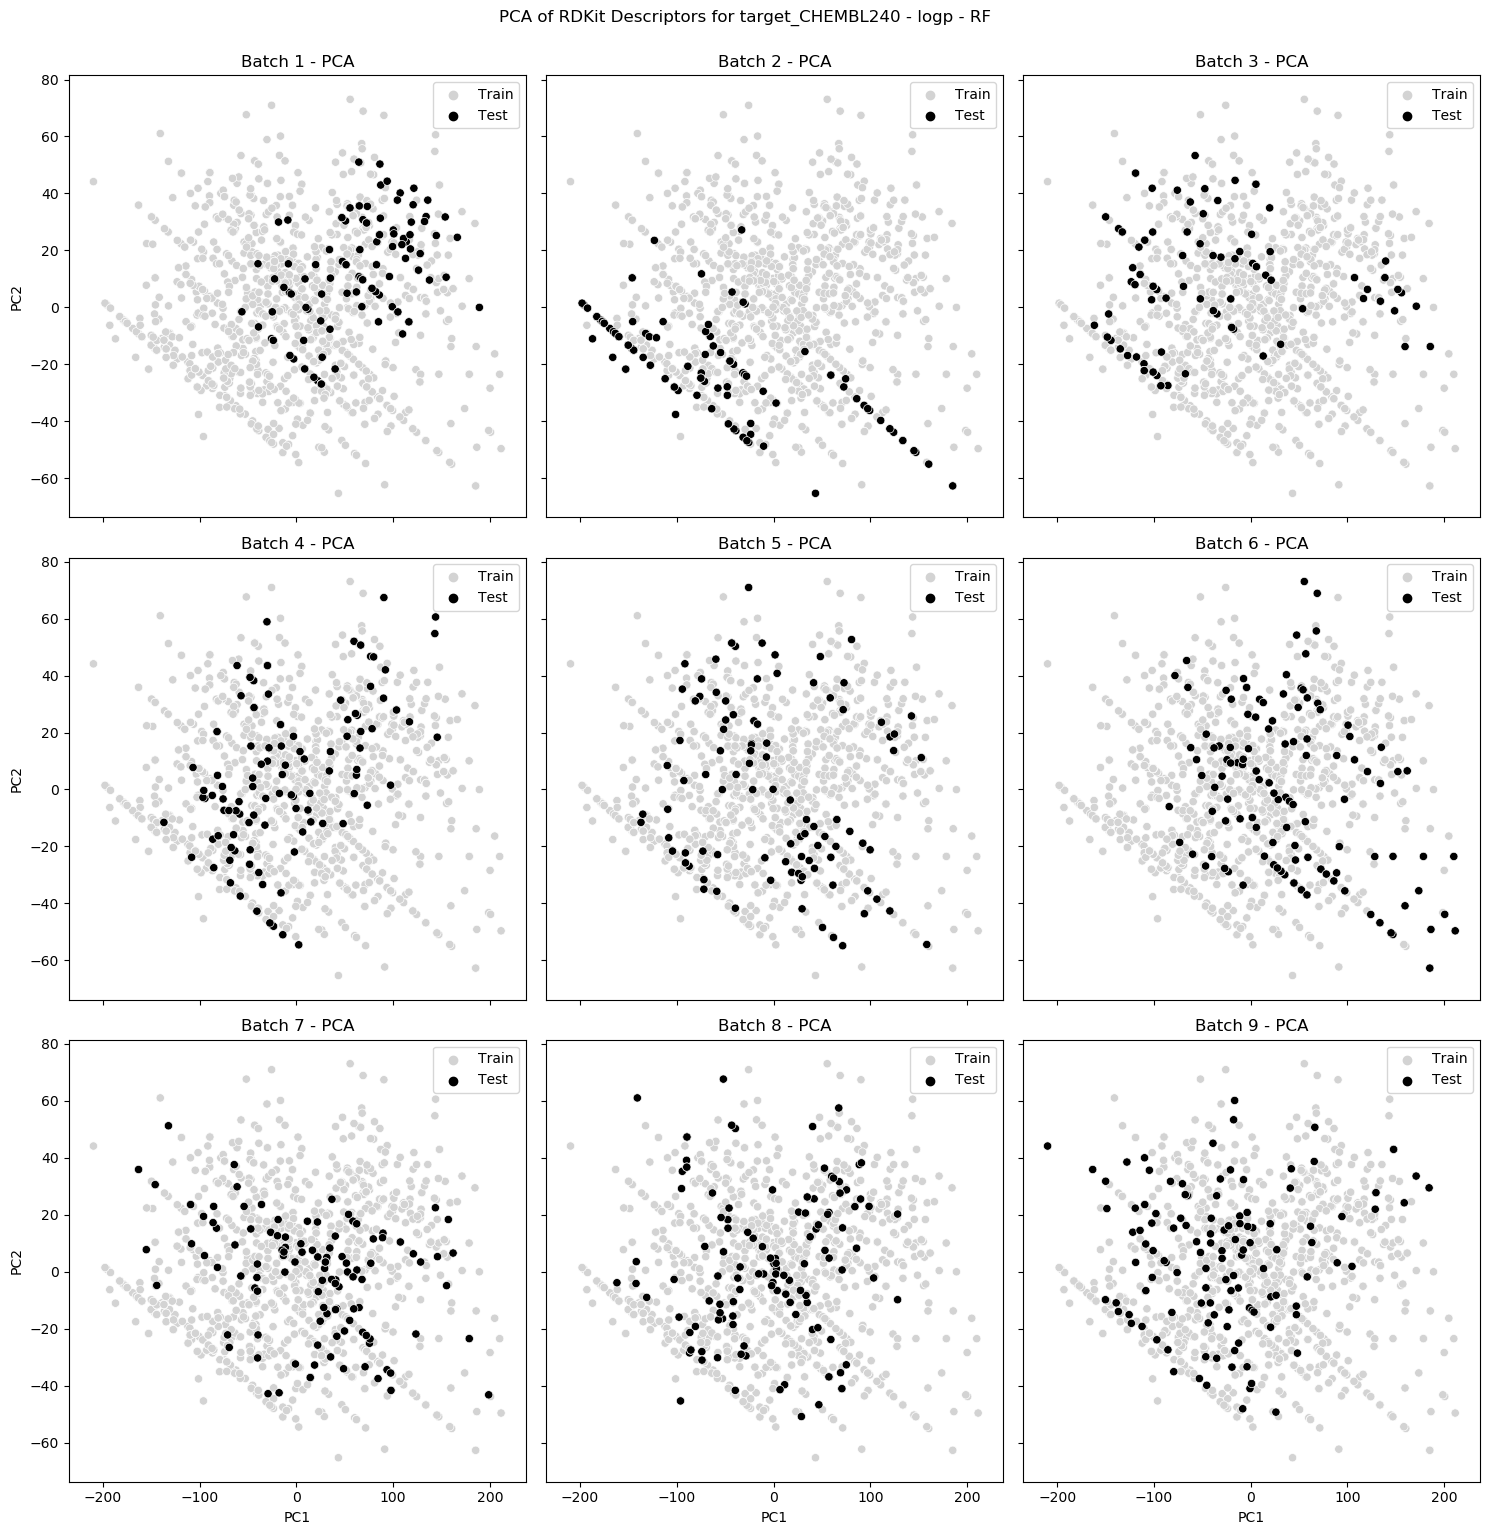

Explained variance by PC1: 0.91
Explained variance by PC2: 0.09


In [11]:

# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("CV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')